### Figure 1: Multi-gene QTL mapping from correlated gene clusters. 

* C: Number of clusters in each tissue vs the percent of all expressed genes
* D: Distribution of the number of genes per cluster
* E: HOXB expression correlation heatmap 
* F: Enrichment of correlated clusters 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import upsetplot as up
from tqdm.auto import tqdm 
from scipy.stats import spearmanr
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
import pyranges as pr

# set higher figure resolution
import matplotlib as mpl


tqdm.pandas()

# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *
from annotate_null_clusters import * 
from residualize import calculate_residual


%config InlineBackend.figure_formats = ['png']
# %matplotlib inline
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 7})

In [ ]:
# colors
corr_cmap = LinearSegmentedColormap.from_list('corr', [(0, '#69AED1'), (.5, 'white'), (1, '#B83A4B')])

gtex_tissue_dict = {
    "Adipose_Subcutaneous": "#FFA54F",
    "Adipose_Visceral_Omentum": "#EE9A00",
    "Artery_Tibial": "#FF0000",
    "Cells_Cultured_fibroblasts": "#9AC0CD",
    "Esophagus_Mucosa": "#8B7355",
    "Esophagus_Muscularis": "#CDAA7D",
    "Lung": "#9ACD32",
    "Muscle_Skeletal": "#7A67EE",
    "Nerve_Tibial": "#FFD700",
    "Skin_Not_Sun_Exposed_Suprapubic": "#3A5FCD",
    "Skin_Sun_Exposed_Lower_leg": "#1E90FF",
    "Thyroid": "#008B45",
    "Whole_Blood": "#FF00FF"
}

gtex_tissue_abbrev = ['ADPSBQ',
                      'ADPVSC',
                      'ARTTBL',
                      'CELLS',
                      'ESPMCS',
                      'ESPMSL',
                      'LUNG',
                      'MSCLSK',
                      'NERVET',
                      'SKINNS',
                      'SKINS',
                      'THYROID',
                      'WHLBLD']

gtex_tissue_pal = sns.color_palette(list(gtex_tissue_dict.values()))
gtex_tissue_pal_df = pd.DataFrame(pd.Series(gtex_tissue_dict), columns=['hex']).reset_index(names=['tissue_id'])


#### C: Number of clusters in each tissue vs the percent of all expressed genes

In [3]:
# load in clusters
clusters = load_across_tissues(config, load_clusters_annotated)

In [ ]:
# get total number of clusters and genes in clusters
cluster_counts = clusters.groupby('tissue_id').agg({'N_genes':sum, 'Transcripts':'nunique'})
tissue_ids = load_tissue_ids(config)

# # get total number of expressed genes
num_expressed_genes = [len(load_expression(config, tissue_id)) for tissue_id in tissue_ids]
cluster_counts['expressed_genes'] = num_expressed_genes
cluster_counts['fraction_genes_in_cluster'] = cluster_counts['N_genes']/cluster_counts['expressed_genes']*100

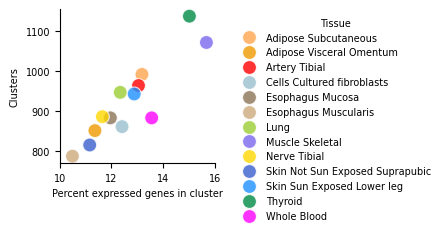

In [ ]:
fig, ax = plt.subplots(figsize=(2,2))

sns.scatterplot(cluster_counts, x='fraction_genes_in_cluster', y='Transcripts', hue='tissue_id', palette=gtex_tissue_pal, ax=ax, s=100, alpha=.8)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.1, 1), frameon=False, title='Tissue')
ax.set_ylabel('Clusters')
ax.set_xlabel('Percent expressed genes in cluster')
ax.set_xticks([10, 12, 14, 16])

legend = ax.get_legend()
new_labels = [label.get_text().replace('_', ' ') for label in legend.texts]
for t, new_label in zip(legend.texts, new_labels):
    t.set_text(new_label)

ax.spines[['top', 'right']].set_visible(False)
plt.savefig(f"/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_1_cluster_counts.pdf", transparent=True)
plt.show()

In [ ]:
cluster_counts['Transcripts'].sum()

12022

#### D: Distribution of the number of genes per cluster


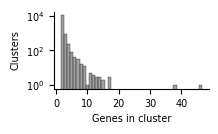

In [ ]:
fig, ax = plt.subplots(figsize=(2,1))
sns.histplot(clusters, x='N_genes', ax=ax, color='grey', discrete=True)
ax.spines[['top', 'right']].set_visible(False)
ax.set_yscale('log')
ax.set_ylabel('Clusters')
ax.set_xlabel('Genes in cluster')
ax.set_yticks([1, 100, 10000])
plt.savefig(f"/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_1_cluster_sizes.pdf", transparent=True)
plt.show()

#### E: HOXB expression correlation heatmap

3


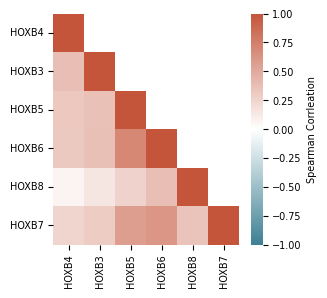

In [9]:
gid_gencode, full_gencode = load_gencode()

def plot_cluster(example_cluster, cbar=False):
    # gene gene ids sorted by tss start
    sorted_cluster = gid_gencode.loc[example_cluster['cluster_id'].split('_')].sort_values('tss_start')
    sorted_gene_ids = sorted_cluster.index.values
    # get normed expression 
    expression = load_cluster_expression(config, example_cluster['Tissue'])
    cluster_expression = expression[(expression['cluster_id']==example_cluster['cluster_id'])].set_index('egene_id').loc[sorted_gene_ids]
    # get correlation of expression
    sample_ids = cluster_expression.columns[cluster_expression.columns.str.contains('GTEX')]
    cluster_corr, cluster_pvalue = spearmanr(cluster_expression[sample_ids], axis=1)
    # make df wtih readable gene names
    cluster_corr = pd.DataFrame(cluster_corr, index=sorted_cluster['gene_name'].values, columns=sorted_cluster['gene_name'].values)

    # make corr plot
    fig_size = int(len(cluster_corr)/2)
    print(fig_size)
    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    sns.heatmap(cluster_corr, mask=np.triu(np.ones_like(cluster_corr), k=1),
                cmap=corr_cmap, vmin=-1, vmax=1, ax=ax, 
                cbar_kws={'label':'Spearman Corrleation'}, 
                xticklabels=True, yticklabels=True, cbar=cbar)
    ax.tick_params("y", rotation=0) 
    plt.show()
     
plot_cluster(clusters[clusters['cluster_id']=='ENSG00000108511.9_ENSG00000120068.6_ENSG00000120075.5_ENSG00000120093.11_ENSG00000182742.5_ENSG00000260027.4'].iloc[0], cbar=True)

#### F: Enrichment of correlated clusters 

In [ ]:
clusters['positive correlation'] = ~clusters['Mean_pos_cor'].isna()
clusters['negative correlation'] = ~clusters['Mean_neg_cor'].isna()
clusters_upset = clusters.set_index('positive correlation').set_index('negative correlation', append=True)

dict_keys(['matrix', 'shading', 'totals', 'intersections'])


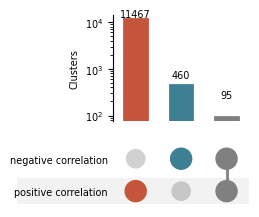

In [ ]:
fig = plt.figure(figsize=(3,2.5))
upset = up.UpSet(clusters_upset, intersection_plot_elements=3, totals_plot_elements = 0, show_counts=True, element_size=None)  # disable the default bar chart

upset.style_subsets(present=["positive correlation"], absent=["negative correlation"], facecolor='#c4553aff', linewidth=2)
upset.style_subsets(present=["negative correlation"], absent=["positive correlation"], facecolor='#3e8093ff', linewidth=2)
upset.style_subsets(present=["positive correlation", "negative correlation"], facecolor='grey', linewidth=2)

# style the instersection plot
plot_result = upset.plot(fig=fig)
print(plot_result.keys())
plt.grid(False)
plot_result['intersections'].set_ylabel("Clusters")
plot_result['intersections'].set_yscale('log')

plt.savefig(f"/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_1_cluster_corr_sign.pdf", transparent=True)
plt.show()

In [ ]:
# get just the ones with matched enahncer
enhancer_tissue_ids = ['Artery_Tibial', 'Cells_Cultured_fibroblasts', 'Lung', 'Muscle_Skeletal', 'Skin_Not_Sun_Exposed_Suprapubic', 'Skin_Sun_Exposed_Lower_leg', 'Thyroid']
combined_clusters = load_across_tissues(config, load_clusters_annotated, tissue_ids = enhancer_tissue_ids)
def load_all_multigene_null(config, tissue_id):
    return pd.concat([load_null_clusters_annotated(config, tissue_id, num_genes) for num_genes in [2,3,4,5]])
combined_multigene_nulls =  load_across_tissues(config, load_all_multigene_null, tissue_ids = enhancer_tissue_ids)

# exclude highly cross mappable genes and add columns
combined_clusters = combined_clusters[~combined_clusters['has_cross_map']]
combined_clusters['has_multiple_abc_genes'] = combined_clusters['num_abc_genes'] > 1
combined_clusters['log_size'] = np.log10(combined_clusters['cluster_tss_size'])
combined_multigene_nulls = combined_multigene_nulls[~combined_multigene_nulls['has_cross_map']]
combined_multigene_nulls['has_multiple_abc_genes'] = combined_multigene_nulls['num_abc_genes'] > 1
combined_multigene_nulls['log_size'] = np.log10(combined_multigene_nulls['cluster_tss_size'])


# make nulls  

# make one without distance matching
multitissue_abc_largerclusters_df = pd.concat([combined_clusters, combined_multigene_nulls], keys=['cluster', 'null'], names=['type', 'idx']).reset_index()
multitissue_abc_largerclusters_df['is_cluster'] = multitissue_abc_largerclusters_df['type']=='cluster'

# make one with distance matching
multitissue_abc_resamp_largerclusters_nulls = []
for num_genes in combined_multigene_nulls['N_genes'].unique():
    cluster_num_genes = combined_clusters[(combined_clusters['N_genes']==num_genes)]
    # don't bother to match if too few clusters of this size, just discard null
    if len(cluster_num_genes) > 2:
        null_num_genes = combined_multigene_nulls[(combined_multigene_nulls['N_genes']==num_genes)]
        multitissue_abc_resamp_largerclusters_nulls.append(get_resamp_null_cluster(null_num_genes, cluster_num_genes, number_null=5000*len(enhancer_tissue_ids), plot=False))

multitissue_abc_resamp_largerclusters_df = pd.concat([combined_clusters, pd.concat(multitissue_abc_resamp_largerclusters_nulls)], keys=['cluster', 'null'], names=['type', 'idx']).reset_index()
multitissue_abc_resamp_largerclusters_df['is_cluster'] = multitissue_abc_resamp_largerclusters_df['type']=='cluster'

/home/klawren/oak/pcqtls/workflow/scripts/annotate_null_clusters.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['normed_log_size'] = np.log10(cluster_df['cluster_tss_size'])/np.log10(join_df['cluster_tss_size'].max())
/home/klawren/oak/pcqtls/workflow/scripts/annotate_null_clusters.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_df['normed_log_size'] = np.log10(null_df['cluster_tss_size'])/np.log10(join_df['cluster_tss_size'].max())
/home/klawren/oak/pcqtls/workflow/scripts/annota

In [ ]:
multitissue_abc_largerclusters_df['corr_type'] = np.where(multitissue_abc_largerclusters_df['Mean_neg_cor'].isna(), 'positive_only', np.where(multitissue_abc_largerclusters_df['Mean_pos_cor'].isna(), 'negative_only', 'mixed'))
# get odds df for positive negative, and mixed corr clusters
multitissue_abc_largerclusters_df['corr_type'] = np.where(multitissue_abc_largerclusters_df['Mean_neg_cor'].isna(), 'positive_only', np.where(multitissue_abc_largerclusters_df['Mean_pos_cor'].isna(), 'negative_only', 'mixed'))

noresamp_cols = ['has_bidirectional_promoter']
noresamp_odds_positive = get_odds_df(multitissue_abc_largerclusters_df[((multitissue_abc_largerclusters_df['type']=='cluster')&(multitissue_abc_largerclusters_df['corr_type']=='positive_only')) | (multitissue_abc_largerclusters_df['type']=='null')], column_list = noresamp_cols, correct_on=True, correct_on_column='N_genes', label_col='is_cluster')
noresamp_odds_all = get_odds_df(multitissue_abc_largerclusters_df[((multitissue_abc_largerclusters_df['type']=='cluster')&(multitissue_abc_largerclusters_df['corr_type']=='mixed')) | (multitissue_abc_largerclusters_df['type']=='null')], column_list = noresamp_cols, correct_on=True, correct_on_column='N_genes', label_col='is_cluster')
noresamp_odds_negative = get_odds_df(multitissue_abc_largerclusters_df[((multitissue_abc_largerclusters_df['type']=='cluster')&(multitissue_abc_largerclusters_df['corr_type']=='negative_only')) | (multitissue_abc_largerclusters_df['type']=='null')], column_list = noresamp_cols, correct_on=True, correct_on_column='N_genes', label_col='is_cluster')


multitissue_abc_resamp_largerclusters_df['corr_type'] = np.where(multitissue_abc_resamp_largerclusters_df['Mean_neg_cor'].isna(), 'positive_only', np.where(multitissue_abc_resamp_largerclusters_df['Mean_pos_cor'].isna(), 'negative_only', 'mixed'))

resamp_column_list = ['has_tads_tss', 
                      'has_paralog', 
                      'has_shared_go_any',
                      'has_ctcf_peak',
                      'has_shared_enhancer']

bool_filter_list = ['has_shared_enhancer']


resamp_odds_positive = get_odds_df(multitissue_abc_resamp_largerclusters_df[((multitissue_abc_resamp_largerclusters_df['type']=='cluster')&(multitissue_abc_resamp_largerclusters_df['corr_type']=='positive_only')) | (multitissue_abc_resamp_largerclusters_df['type']=='null')], column_list=resamp_column_list, filter_list=bool_filter_list, correct_on=True, correct_on_column='N_genes', label_col='is_cluster') 
resamp_odds_all = get_odds_df(multitissue_abc_resamp_largerclusters_df[((multitissue_abc_resamp_largerclusters_df['type']=='cluster')&(multitissue_abc_resamp_largerclusters_df['corr_type']=='mixed')) | (multitissue_abc_resamp_largerclusters_df['type']=='null')], column_list=resamp_column_list, filter_list=bool_filter_list, correct_on=True, correct_on_column='N_genes', label_col='is_cluster')
resamp_odds_negative = get_odds_df(multitissue_abc_resamp_largerclusters_df[((multitissue_abc_resamp_largerclusters_df['type']=='cluster')&(multitissue_abc_resamp_largerclusters_df['corr_type']=='negative_only')) | (multitissue_abc_resamp_largerclusters_df['type']=='null')], column_list=resamp_column_list, filter_list=bool_filter_list, correct_on=True, correct_on_column='N_genes', label_col='is_cluster')


has_bidirectional_promoter
Optimization terminated successfully.
         Current function value: 0.135935
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               137956
Model:                          Logit   Df Residuals:                   137953
Method:                           MLE   Df Model:                            2
Date:                Tue, 20 May 2025   Pseudo R-squ.:                  0.2223
Time:                        20:25:05   Log-Likelihood:                -18753.
converged:                       True   LL-Null:                       -24113.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          2.4293      0.077

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               132367
Model:                          Logit   Df Residuals:                   132364
Method:                           MLE   Df Model:                            2
Date:                Tue, 20 May 2025   Pseudo R-squ.:                  0.1885
Time:                        20:25:08   Log-Likelihood:                -1367.5
converged:                      False   LL-Null:                       -1685.2
Covariance Type:            nonrobust   LLR p-value:                1.077e-138
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         22.0943    114.758      0.193      0.847    -202.826     247.015
N_genes                      -13.5941     57.379     -0.237      0.813    -126.054 

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               118795
Model:                          Logit   Df Residuals:                   118792
Method:                           MLE   Df Model:                            2
Date:                Tue, 20 May 2025   Pseudo R-squ.:                 0.05199
Time:                        20:25:22   Log-Likelihood:                -183.71
converged:                      False   LL-Null:                       -193.79
Covariance Type:            nonrobust   LLR p-value:                 4.216e-05
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -30.3440   8086.979     -0.004      0.997   -1.59e+04    1.58e+04
N_genes                 0.8856      0.183      4.847      0.000       0.528       1.244
has_shared_enhan

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


         Current function value: 0.009995
         Iterations: 35


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               140229
Model:                          Logit   Df Residuals:                   140226
Method:                           MLE   Df Model:                            2
Date:                Tue, 20 May 2025   Pseudo R-squ.:                  0.1748
Time:                        20:25:24   Log-Likelihood:                -1401.6
converged:                      False   LL-Null:                       -1698.4
Covariance Type:            nonrobust   LLR p-value:                1.252e-129
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0629      0.435     -0.145      0.885      -0.916       0.790
N_genes         -2.4936      0.207    -12.068      0.000      -2.899      -2.089
has_tads_tss    -0.0222      0.151     -0.14

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               140229
Model:                          Logit   Df Residuals:                   140226
Method:                           MLE   Df Model:                            2
Date:                Tue, 20 May 2025   Pseudo R-squ.:                  0.1873
Time:                        20:25:26   Log-Likelihood:                -1380.3
converged:                      False   LL-Null:                       -1698.4
Covariance Type:            nonrobust   LLR p-value:                7.174e-139
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          22.9345    143.394      0.160      0.873    -258.112     303.981
N_genes       -13.9942     71.697     -0.195      0.845    -154.517     126.529
has_paralog     0.4259      0.260      1.635    

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               140229
Model:                          Logit   Df Residuals:                   140226
Method:                           MLE   Df Model:                            2
Date:                Tue, 20 May 2025   Pseudo R-squ.:                  0.1870
Time:                        20:25:28   Log-Likelihood:                -1380.7
converged:                      False   LL-Null:                       -1698.4
Covariance Type:            nonrobust   LLR p-value:                1.094e-138
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                26.5696    359.455      0.074      0.941    -677.950     731.089
N_genes             -15.7863    179.728     -0.088      0.930    -368.046     336.473
has_shared_go_any    -0.

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


         Current function value: 0.009846
         Iterations: 35


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               140229
Model:                          Logit   Df Residuals:                   140226
Method:                           MLE   Df Model:                            2
Date:                Tue, 20 May 2025   Pseudo R-squ.:                  0.1870
Time:                        20:25:30   Log-Likelihood:                -1380.7
converged:                      False   LL-Null:                       -1698.4
Covariance Type:            nonrobust   LLR p-value:                1.085e-138
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            28.8990    644.252      0.045      0.964   -1233.812    1291.610
N_genes         -17.0088    322.126     -0.053      0.958    -648.364     614.347
has_ctcf_peak     0.1657      0.134     

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


         Current function value: 0.007717
         Iterations: 35


/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               118929
Model:                          Logit   Df Residuals:                   118926
Method:                           MLE   Df Model:                            2
Date:                Tue, 20 May 2025   Pseudo R-squ.:                  0.2208
Time:                        20:25:32   Log-Likelihood:                -917.77
converged:                      False   LL-Null:                       -1177.9
Covariance Type:            nonrobust   LLR p-value:                1.070e-113
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  35.5501   3249.564      0.011      0.991   -6333.479    6404.579
N_genes               -20.1211   1624.782     -0.012      0.990   -3204.636    3164.393
has_shared_enhan

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


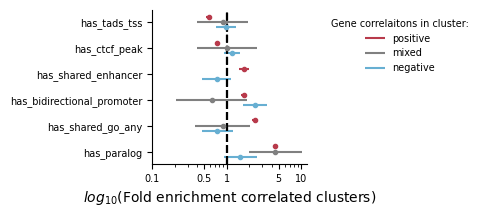

In [ ]:
# combined, resampled and nonresampled columns
col_order = ['has_tads_tss', 'has_ctcf_peak', 'has_shared_enhancer', 'has_bidirectional_promoter', 'has_shared_go_any', 'has_paralog'][::-1]
odds_negative = pd.concat([noresamp_odds_negative, resamp_odds_negative]).loc[col_order] 
odds_all = pd.concat([noresamp_odds_all, resamp_odds_all]).loc[col_order] 
odds_positive = pd.concat([noresamp_odds_positive, resamp_odds_positive]).loc[col_order] 

fig, ax = plt.subplots(figsize=(2, 2))

# make the plot
make_log_odds_plot_multiple([odds_negative, odds_all, odds_positive], 
                             labels=['negative', 'mixed', 'positive',], 
                             colors = sns.color_palette('blend:#67AFD2,grey,#B83A4B', n_colors=3), 
                             add_annotations=False, offset=.2, ax=ax)

ax.set_xlabel(r'$log_{10}$(Fold enrichment correlated clusters)', fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.set_yticklabels([])
ax.set_xlim([.1, 12])
ax.set_xticks([.1, .5, 1, 5, 10], labels=[.1, .5, 1, 5, 10])

# customize the legend
legend = ax.get_legend()
legend.get_frame().set_visible(False)
legend.set_title("Gene correlaitons in cluster:")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.1, 1))
plt.savefig(f"/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_1_cluster_enrichments.pdf", transparent=True)
plt.show()
